In [1]:
import numpy as np
import os


class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 


def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [2]:
metadata = load_metadata('PINS')

In [3]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [4]:
load_image(metadata[0].image_path())

array([[[233, 188, 165],
        [231, 186, 163],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[232, 187, 164],
        [233, 188, 165],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[230, 186, 161],
        [228, 184, 159],
        [206, 164, 140],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       ...,

       [[198, 118,  91],
        [197, 120,  94],
        [195, 119,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[200, 120,  93],
        [200, 120,  93],
        [198, 121,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[201, 121,  94],
        [201, 121,  94],
        [199, 122,  96],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]]

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation


def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [8]:
from tensorflow.keras.models import model_from_json
model = vgg_face()
model.load_weights('vgg_face_weights.h5')

In [9]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [10]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 521ms/step
(2622,)


In [11]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        # scale RGB values to interval [0,1]
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    except Exception as e:
        print(str(e))
        print(i,m)

1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 218ms/step


1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 192ms/step


1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 198ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 234ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 217ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 335ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 213ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 220ms/step


1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 0s 345ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 444ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 423ms/step


1/1 [==============================] - 0s 430ms/step


1/1 [==============================] - 0s 433ms/step


1/1 [==============================] - 0s 423ms/step


1/1 [==============================] - 0s 439ms/step


1/1 [==============================] - 0s 466ms/step


1/1 [==============================] - 0s 455ms/step


1/1 [==============================] - 0s 454ms/step


1/1 [==============================] - 0s 479ms/step


1/1 [==============================] - 0s 470ms/step


1/1 [==============================] - 1s 514ms/step


1/1 [==============================] - 1s 502ms/step


1/1 [==============================] - 1s 549ms/step


1/1 [==============================] - 1s 565ms/step


1/1 [==============================] - 1s 581ms/step


1/1 [==============================] - 1s 627ms/step


1/1 [==============================] - 1s 637ms/step


1/1 [==============================] - 1s 666ms/step


1/1 [==============================] - 1s 699ms/step


1/1 [==============================] - 1s 862ms/step


1/1 [==============================] - 1s 839ms/step


In [12]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

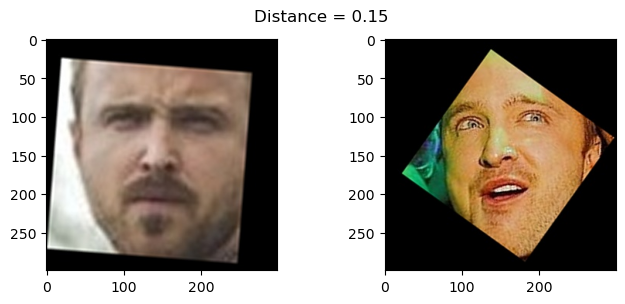

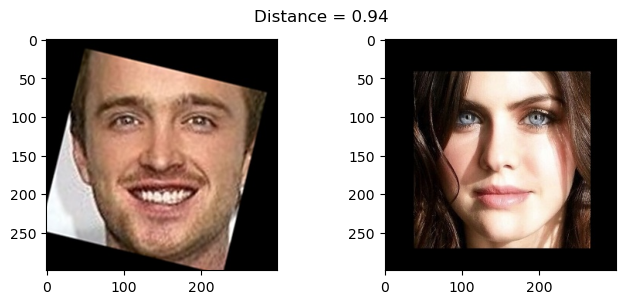

In [14]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(4, 8)
show_pair(20, 180)

In [16]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [18]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [20]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight=None , C=10000000, gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9640768588137009

In [34]:
rock = cv2.imread('dj.jpg')
dr_strange = cv2.imread('dr.jpg')

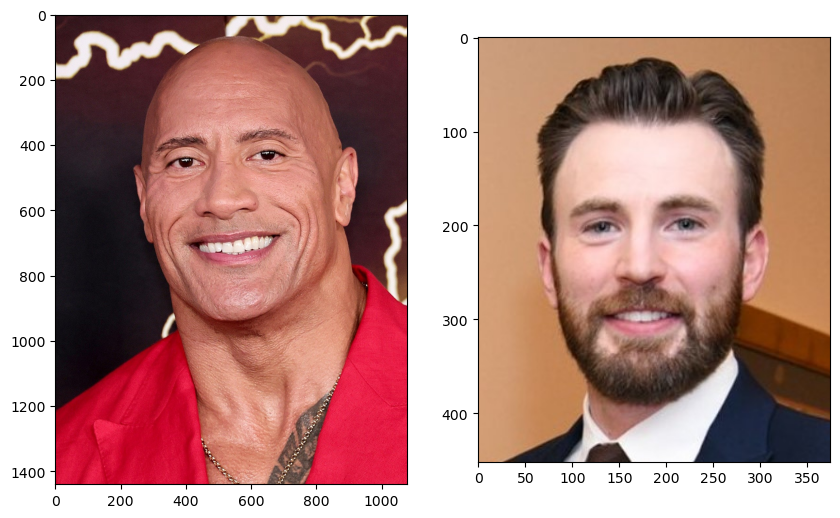

In [35]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(rock[...,::-1])
plt.subplot(122)
plt.imshow(dr_strange[...,::-1])

In [36]:
img = load_image('dj.jpg')
img = cv2.resize(img, dsize = (224,224))
img = (img / 255.).astype(np.float32)

In [37]:
def preprocess_test_img(path_to_img):
    orig_img = load_image(path_to_img)
    img = cv2.resize(orig_img, dsize = (224,224))
    img = (img / 255.).astype(np.float32)
    img = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    img = np.expand_dims(img,0)
    img = sc.transform(img)
    img = pca.transform(img)
    return orig_img,img

1/1 [==============================] - 1s 683ms/step


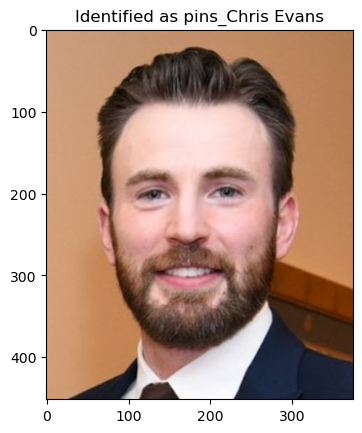

In [38]:
orig_img, tst_img = preprocess_test_img('dr.jpg')
pred = clf.predict(tst_img)
ret = encoder.inverse_transform(pred)[0]
plt.imshow(orig_img)
plt.title(f'Identified as {ret}');

1/1 [==============================] - 1s 647ms/step


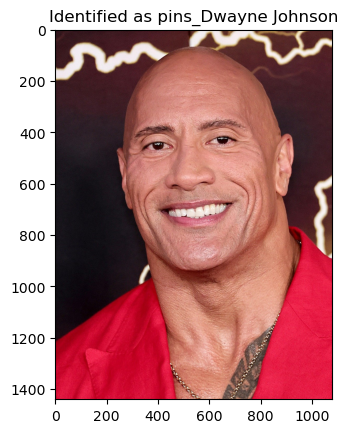

In [39]:
orig_img, tst_img = preprocess_test_img('dj.jpg')
pred = clf.predict(tst_img)
ret = encoder.inverse_transform(pred)[0]
plt.imshow(orig_img)
plt.title(f'Identified as {ret}');